# Project Overview

## Introduction

This document presents the process of a data-driven project aimed at developing a robust predictive model for diamond valuation. As the lead Data Engineer on this initiative, my focus has been on leveraging advanced statistical methods and machine learning techniques to replace the need for manual appraisal with a reliable, algorithm-based valuation tool.

## Project Context

The essence of this project lies in its application to the valuation of a diverse collection of 5000 diamonds previously assessed by an expert gemologist. My task was to create a model that encapsulates the years of expertise into a quantifiable and repeatable form, ensuring accuracy and consistency in diamond pricing.

## Objective

The primary goal has been to construct a predictive model that can accurately determine the value of a diamond based on its attributes without the subjective variability introduced by human appraisers. This model aims to uphold the high standards of quality and service established by our clients while introducing efficiency and scalability into the valuation process.

The following sections will detail the methodologies employed, the insights gained, and the results achieved. I am confident that the predictive model developed will serve as a cornerstone in the evaluation of diamonds.

In [ ]:
!pip install -r requirements.txt

In [4]:
# Importing necessary libraries for data manipulation, statistical operations, and machine learning.
import pandas as pd # Data manipulation and analysis
import numpy as np # Numerical operations

# Sklearn modules for preprocessing and model selection
from sklearn.model_selection import train_test_split # Splitting the dataset
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV # Regression algorithms 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score # Model evaluation metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler # Preprocessing utilities

# Matplotlib for plotting
import matplotlib.pyplot as plt # Basic plotting

# Data Loading and Preprocessing

### Loading the Dataset

The first step in our analysis is to load the diamond dataset into a pandas DataFrame.

In [5]:
# Load the dataset into a pandas DataFrame
data_path = 'datasets/diamonds/diamonds.csv'
df = pd.read_csv(data_path) 

## EDA

Now we must continue with some Exploratory Data Analysis, to get a good grasp of our data before attempting to build a model.

## Descriptive Statistics for Diamond Prices:

- **Count:** The dataset contains prices for 4990 diamonds.
- **Mean:** The average price of diamonds in the dataset is \$3,933.48.
- **Standard Deviation:** The prices have a standard deviation of \$3,975.54, indicating a wide variation in diamond prices.
- **Minimum Price:** The least expensive diamond is priced at \$351.
- **25th Percentile:** 25% of the diamonds are priced at or below \$942.
- **Median (50th Percentile):** The median price of diamonds is \$2,398, which indicates that half of the diamonds are priced below this amount.
- **75th Percentile:** 75% of the diamonds are priced at or below \$5,377.50.
- **Maximum Price:** The most expensive diamond in the dataset is priced at \$18,787.

## Distribution of Diamond Prices Histogram:

- The histogram shows the frequency distribution of diamond prices.
- The **mean price** is represented by a red dashed line at \$3,933.41.
- The **median price** is represented by a green dashed line at \$2,398.00.
- Most of the diamond prices are clustered on the left side of the histogram, indicating a right-skewed distribution.
- There are a few diamonds with very high prices, which create a long tail on the right side of the distribution.

Descriptive Statistics for Diamond Prices:
count     5000.00000
mean      3925.53940
std       3975.45212
min         -1.00000
25%        936.00000
50%       2392.50000
75%       5369.25000
max      18787.00000
Name: price, dtype: float64


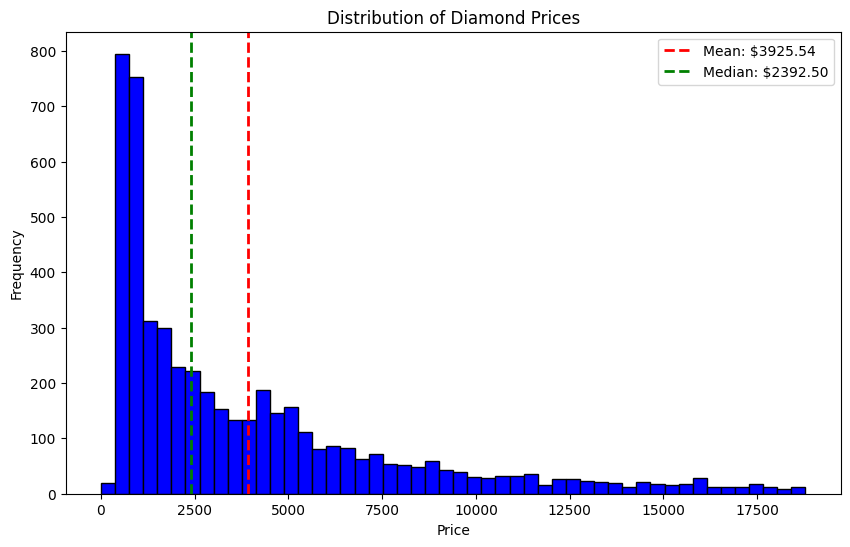

In [6]:
# Descriptive statistics for the original prices
price_stats = df['price'].describe()

# Printing the descriptive statistics
print("Descriptive Statistics for Diamond Prices:")
print(price_stats)

# Histogram of the price distribution
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Diamond Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.axvline(df['price'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: ${df['price'].mean():.2f}")
plt.axvline(df['price'].median(), color='green', linestyle='dashed', linewidth=2, label=f"Median: ${df['price'].median():.2f}")
plt.legend()
plt.show()

### Data Cleaning

Upon loading the data, we proceed to cleanse it by removing any entries that don't make sense for our analysis; specifically, we eliminate any diamonds with a non-positive price, as these values are likely to be errors or placeholders.

In [7]:
# Remove rows where the price is non-positive as these do not contribute to our analysis and they are very few
df = df[df['price'] > 0]

### Preparing Categorical Variables

Since our dataset contains categorical variables such as 'cut', 'color', and 'clarity', we need to convert these into a numerical format. We achieve this through label encoding, which transforms the categories into a set of integers.

In [8]:
# Perform label encoding on categorical variables to convert them into numerical values
le_cut = LabelEncoder()
df['cut'] = le_cut.fit_transform(df['cut']) # Encoding 'cut' category

le_color = LabelEncoder()
df['color'] = le_color.fit_transform(df['color']) # Encoding 'color' category

le_clarity = LabelEncoder()
df['clarity'] = le_clarity.fit_transform(df['clarity']) # Encoding 'clarity' category

# Feature Engineering and Data Splitting

### Log Transformation 

To deal with potential skewness in the price distribution, we apply a log transformation to the target variable. This can help improve the performance of the model by stabilizing variance and making the distribution more normal.

In [9]:
# Applying a log transformation to the target variable (price) to improve normality
df['price_log'] = np.log(df['price'])

### Feature Selection

We define our feature set to include diamond characteristics known to influence price, such as carat, cut, color, clarity, and physical dimensions.

In [10]:
# Selection of features for the regression model
X = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']]
y = df['price_log']

### Train-Test Split

We split our dataset into training and testing sets, allocating 80% of the data for training and 20% for testing.

In [11]:
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Standardization

To ensure that all features contribute equally to the model prediction, we standardize them. This involves scaling the features so they have a mean of zero and a standard deviation of one, which is particularly important for models that are sensitive to the scale of the data, like Ridge and Lasso regression.

In [12]:
# Standardizing features to have a mean=0 and variance=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Selection with Regularization

We prepare to use Ridge and Lasso regression models, both of which include regularization to prevent overfitting. Cross-validation is employed to select the best regularization parameter (alpha) for each model, ensuring we find a balance between bias and variance.

In [13]:
# Using Ridge and Lasso regression with cross-validation to determine the optimal regularization strength
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5, max_iter=100000)

## Model Training, Prediction, and Evaluation

### Training and Prediction

We have trained both Ridge and Lasso regression models using our scaled training dataset. Post-training, we predict the log-transformed prices for our test set, then convert these log prices back to their original scale for interpretability.

In [14]:
# Training the Ridge and Lasso regression models on the scaled training data
ridge_cv.fit(X_train_scaled, y_train)
lasso_cv.fit(X_train_scaled, y_train)

# Making predictions on the test set using the Ridge regression model
# The predictions are transformed back to the original price scale from the log scale
y_pred_ridge_log = ridge_cv.predict(X_test_scaled)
y_pred_ridge = np.exp(y_pred_ridge_log)

# Making predictions on the test set using the Lasso regression model
# Similar to Ridge, predictions are reverted back to the original price scale
y_pred_lasso_log = lasso_cv.predict(X_test_scaled)
y_pred_lasso = np.exp(y_pred_lasso_log)

### Ensemble Prediction

By averaging the predictions from both models, we potentially capitalize on the strengths of each model and mitigate their individual weaknesses.

In [15]:
# Combining the predictions of Ridge and Lasso models by averaging
# This ensemble approach can sometimes yield better predictions than individual models
y_pred_combined = (y_pred_ridge + y_pred_lasso) / 2

### Performance Metrics

We evaluate our combined model using a range of metrics. These metrics give us a comprehensive view of our model's accuracy and predictive power.

### Combined Model Performance Evaluation

Our combined regression model, which averages predictions from both Ridge and Lasso models, shows the following performance metrics:

- **Mean Absolute Error (MAE)**: 652.62
  - On average, the model's predictions are approximately $652.62 away from the actual diamond prices. This provides an idea of the average magnitude of errors in the predictions.

- **Mean Squared Error (MSE)**: 1,848,038.14
  - The MSE, being a squared metric, penalizes larger errors more severely. An MSE of approximately 1.85 million suggests that there are some significant deviations for certain predictions.

- **Root Mean Squared Error (RMSE)**: 1,356.77
  - The RMSE is more interpretable in the same units as the target variable. With an RMSE of $1,356.77, this metric also indicates the standard deviation of the residuals and gives a sense of the typical error magnitude.

- **R-squared Score**: 0.88
  - The R-squared value, representing the proportion of the variance in the dependent variable that is predictable from the independent variables, is 0.88. This indicates a very high level of explanatory power, with the model accounting for 88% of the variability in diamond prices.

- **Explained Variance Score**: 0.88
  - Similarly, the explained variance score of 0.88 confirms that our model has a strong predictive power, with a high degree of correlation between the actual and predicted values.

The metrics suggest that the model is quite effective, with a high R-squared and explained variance score indicating good fit. However, the relatively high values of MAE and RMSE point out that there are still notable errors in some predictions. It may be beneficial to further analyze the residuals to understand the nature of these errors and to explore if there are specific areas or types of diamonds where the model can be improved.


## Model Accuracy Metrics:

- **Mean Absolute Error (MAE) as a Percentage of Mean Price:** The MAE is 16.59% of the mean price, indicating the average magnitude of the errors in the predictions made by the model.
- **Mean Absolute Error as a Percentage of Median Price:** The MAE is 27.21% of the median price, which might be more indicative of the model performance given the skewed distribution of diamond prices.

In [16]:
# Evaluation of the combined model using various metrics
# Mean Absolute Error (MAE), Mean Squared Error (MSE), Root MSE (RMSE), R-squared, and Explained Variance
# These metrics provide insights into the accuracy and performance of the model
mae_combined = mean_absolute_error(np.exp(y_test), y_pred_combined)
mse_combined = mean_squared_error(np.exp(y_test), y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
r2_combined = r2_score(np.exp(y_test), y_pred_combined)
explained_variance_combined = explained_variance_score(np.exp(y_test), y_pred_combined)

# Output the evaluation metrics to the console
print(f'Mean Absolute Error: {mae_combined}')
print(f'Mean Squared Error: {mse_combined}')
print(f'Root Mean Squared Error: {rmse_combined}')
print(f'R-squared Score: {r2_combined}')
print(f'Explained Variance Score: {explained_variance_combined}')

Mean Absolute Error: 652.6022099405723
Mean Squared Error: 1840830.1425841677
Root Mean Squared Error: 1356.7719567356069
R-squared Score: 0.8750472018376059
Explained Variance Score: 0.8753451236992122


In [17]:
# Percentage errors in relation to mean and median
mae_percent_mean = (mae_combined / price_stats['mean']) * 100
mae_percent_median = (mae_combined / price_stats['50%']) * 100

# Printing the percentage errors
print(f"\nMAE as a percentage of Mean Price: {mae_percent_mean:.2f}%")
print(f"MAE as a percentage of Median Price: {mae_percent_median:.2f}%")


MAE as a percentage of Mean Price: 16.62%
MAE as a percentage of Median Price: 27.28%


### Residual Analysis

We plot the residuals against predicted prices to assess the variance of our model's errors. A random distribution of residuals around the horizontal line at zero suggests good model performance.

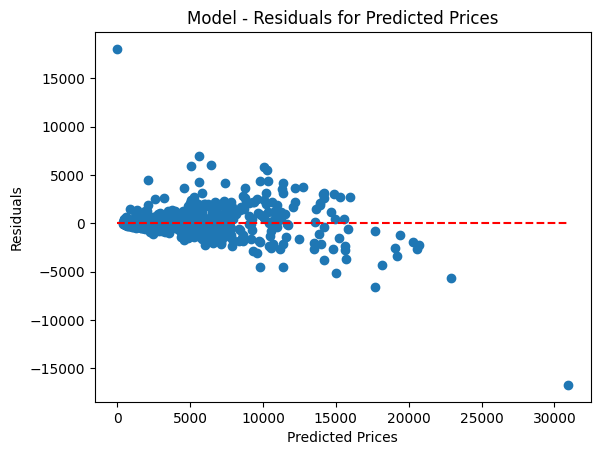

In [18]:
# Visualizing the residuals of the combined model
# Residuals are the differences between the actual and predicted prices
# This plot helps to assess the distribution of errors
residuals_combined = np.exp(y_test) - y_pred_combined
plt.scatter(y_pred_combined, residuals_combined)
plt.hlines(y=0, xmin=y_pred_combined.min(), xmax=y_pred_combined.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Model - Residuals for Predicted Prices')
plt.show()

### Actual vs. Predicted Price Comparison

Finally, we visualize the actual versus predicted prices. Points closely aligned along the diagonal indicate accurate predictions. This graph provides a quick visual assessment of model accuracy.

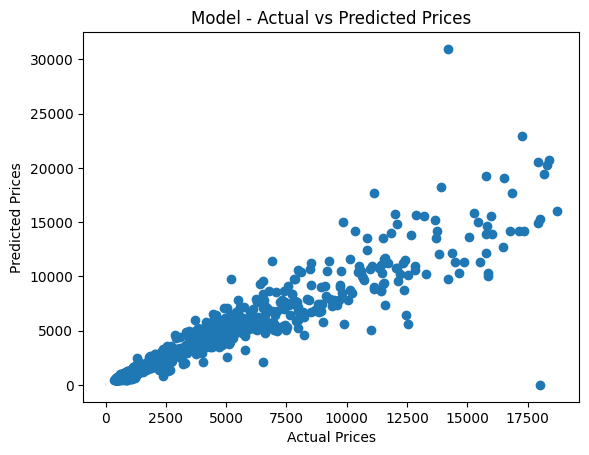

In [19]:
# Visual comparison of the actual and predicted prices
# A 45-degree line represents the perfect prediction scenario
plt.scatter(np.exp(y_test), y_pred_combined)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Model - Actual vs Predicted Prices')
plt.show()

The distribution and the model accuracy metrics suggest that while the model has a reasonable level of accuracy, there is a significant variation in the data, and the predictions may be less accurate for diamonds with prices around the median value.